In [1]:
import os
from os.path import expanduser
import socket
import sys
import glob

# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#########################################

In [2]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

import xarray as xr
import pandas as pd

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

No joblib
no cmocean


In [3]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'tr10'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [4]:
time = pd.date_range('1985-01-01', freq="M", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = time

In [5]:
data

<xarray.Dataset>
Dimensions:  (nod3d: 16950142, time: 372)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-31 1985-02-28 ... 2015-12-31
Dimensions without coordinates: nod3d
Data variables:
    tr10     (time, nod3d) float64 dask.array<shape=(372, 16950142), chunksize=(12, 16950142)>
Attributes:
    description:  REcoM tracer 10
    history:      Created Wed Dec  9 16:53:00 2020

In [6]:
yearly_data = data.resample(time='1A').sum(dim='time')
yearly_data['tr10'] *= 30
yearly_data = yearly_data.compute()

In [7]:
yearly_data

<xarray.Dataset>
Dimensions:  (nod3d: 16950142, time: 31)
Coordinates:
  * time     (time) datetime64[ns] 1985-12-31 1986-12-31 ... 2015-12-31
Dimensions without coordinates: nod3d
Data variables:
    tr10     (time, nod3d) float64 3.984e-06 3.868e-06 ... 8.028e-14 8.028e-14

In [8]:
ANPP_sel = yearly_data.tr10.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
ANPP_sel = ANPP_sel.compute()

ANPP_mean = ANPP_sel.mean(dim='time')
ANPP_mean = ANPP_mean.compute()
# ANPP_min = ANPP_sel.min(dim='time')
# ANPP_min = ANPP_min.compute()

In [9]:
print years.shape
print ANPP_sel.shape

(31,)
(31, 16950142)


In [10]:
pf = np.polyfit(years, ANPP_sel, 1)

In [11]:
ANPP_trend = pf[0]

In [12]:
import pyfesom as pf
data, elem_no_nan = pf.get_data(ANPP_trend,mesh,0)

data2=np.copy(data)
data2 = 100 * data2 *12.01 / 1000
print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.mean(data2)
print 'Max and min: ',np.max(data2),np.min(data2)

For depth 0 model level -0.0 will be used
Number of nans in tracer:  0
Number of inf in tracer:  0
Mean of surface:  0.2629893644809615
Max and min:  78.4367828345991 -24.507529457155627


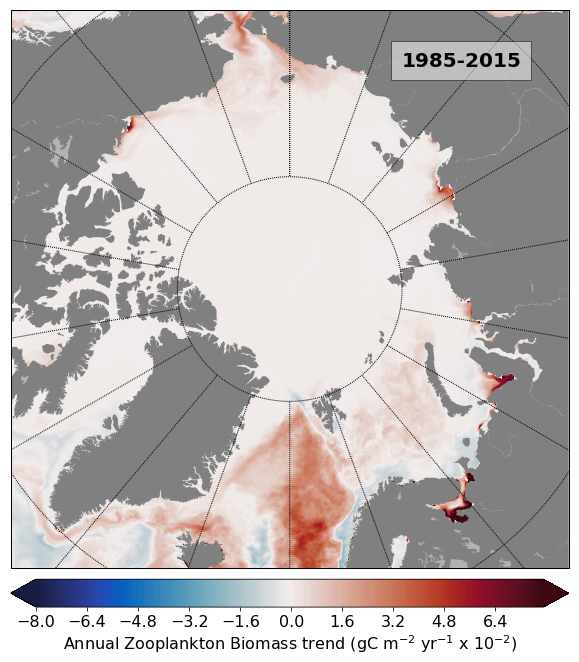

In [13]:
contours = np.arange(-8, 8, .1)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=65,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.9')
m.fillcontinents(color='.5',lake_color='.7')

#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2, levels=contours, cmap=cmap.cm.balance, extend='both')

plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

label = 'Annual Zooplankton Biomass trend (gC m$^{-2}$ yr$^{-1}$ x 10$^{-2}$)'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(wd_path+'figures/'+runid+'/trend/AZB.png', dpi = 200, bbox_inches='tight')
plt.show()

In [14]:
data, elem_no_nan = pf.get_data(ANPP_mean,mesh,0)

data2=np.copy(data)
data2 = data2 *12.01 / 1000

print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.mean(data2)
print 'Max and min: ',np.max(data2),np.min(data2)

For depth 0 model level -0.0 will be used
Number of nans in tracer:  0
Number of inf in tracer:  0
Mean of surface:  0.5357680311961578
Max and min:  21.748908678411667 9.64162881027037e-16


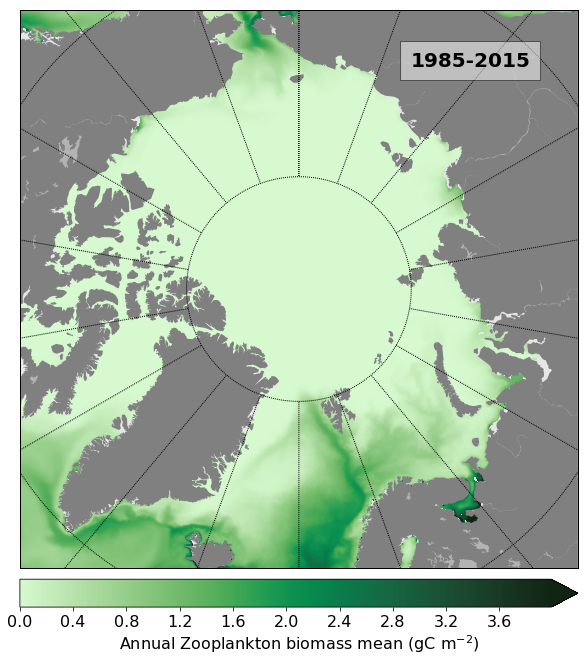

In [15]:
contours = np.arange(0, 4, 0.01)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=65,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.9')
m.fillcontinents(color='.5',lake_color='.7')

#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2, levels=contours, cmap=cmap.cm.algae, extend='max')

plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

label = 'Annual Zooplankton biomass mean (gC m$^{-2}$)'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16) 

plt.savefig(wd_path+'figures/'+runid+'/meanstate/AZB.png', dpi = 200, bbox_inches='tight')

plt.show()

In [16]:
data0, elem_no_nan = pf.get_data(ANPP_mean,mesh,0)
data1, elem_no_nan = pf.get_data(ANPP_trend,mesh,0)
data2 = data1 / data0

data2=np.copy(data2)
data2 = data2 *100

print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.mean(data2)
print 'Max and min: ',np.max(data2),np.min(data2)

For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
Number of nans in tracer:  0
Number of inf in tracer:  0
Mean of surface:  1.4388811867816833
Max and min:  18.74947579024108 -18.728244026920954


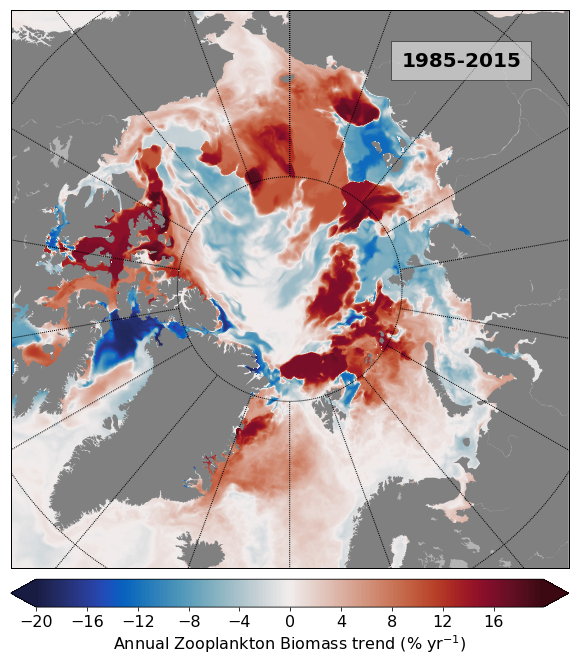

In [17]:
contours = np.arange(-20, 20, .1)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=65,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.9')
m.fillcontinents(color='.5',lake_color='.7')

#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2, levels=contours, cmap=cmap.cm.balance, extend='both')

plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

label = 'Annual Zooplankton Biomass trend (% yr$^{-1}$)'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(wd_path+'figures/'+runid+'/trend/AZBrel.png', dpi = 200, bbox_inches='tight')
plt.show()